<a href="https://www.kaggle.com/code/oscarfraley/predicting-fpl-points?scriptVersionId=163607647" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting FPL Points

The increasing popular game: Fantasy Premier League, has captured the hearts of many football fans, with good gameweeks igniting estasy, and bad gameweeks supplying misery. Amoungst other things, a good fantasy football manager is defined by his/her ability to predict players gameweek points accurately, and putting aside their subjective feelings and emotions. This begs the questions: can we leverage the power of data science to provide an objective tool to predict player points? In this notebook I attempt this, framed as a regression problem, and use the results to create my own dream-team for each upcoming gameweek. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
import math

# Data

## Raw Data Exploration

All data is aquired from https://github.com/vaastav/Fantasy-Premier-League which provides the statistics of every FPL player for each gameweek. Below is an example file from gameweek 5 of the 2023 season.

In [2]:
example_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/gw5.csv'
example_data = pd.read_csv(example_url)

In [3]:
example_data.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Femi Seriki,DEF,Sheffield Utd,-0.5,0,0,0,0,0.0,653,...,1,2,0.0,0,188,644,456,40,False,0
1,Radek Vítek,GK,Man Utd,0.5,0,0,0,0,0.0,669,...,3,1,0.0,0,230,375,145,40,True,0
2,Jack Hinshelwood,MID,Brighton,-0.5,0,0,0,0,0.0,621,...,3,1,0.0,0,33,171,138,45,False,0
3,Jadon Sancho,MID,Man Utd,0.0,0,0,0,0,0.0,397,...,3,1,0.0,0,-10596,796,11392,68,True,0
4,Divock Origi,FWD,Nott'm Forest,2.0,0,0,3,0,0.0,714,...,1,1,4.0,1,6189,6982,793,50,True,0


## Data Extraction Class

Raw data is manipulated into a dataframe in which each index represents a player from a specific gameweek and contains form (recent averages: xG, xA ...) and fixture (opposition recent average xGC, home/away) information. The target variable is the players true points scored that particular gameweek. The class below creates a dataframe for a particular gameweek specified as the input.

In [4]:
class PlayerData: # Base class containing functions used in training and prediction.
    def __init__(self, gw, season, form_range=4):
        self.gw = gw
        self.range = form_range
        self.season = season
        self.form_data = self.get_form_data()
        
    def get_url(self, lag): 
        return 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20' \
               + str(self.season) + '-' + str(self.season + 1) + '/gws/gw' + str(self.gw - lag) + '.csv'

    def get_form_data(self): # Extracts recent player statistics and calculated an average.
        data = pd.DataFrame()
        for i in range(self.range):
            url = self.get_url(i+1)
            temp = pd.read_csv(url).drop(['kickoff_time', 'was_home', 'expected_goals_conceded', 'starts', 'element', 'team_a_score', 'team_h_score', 'round', 'penalties_missed', 'penalties_saved', 'own_goals'], axis=1)
            temp = temp.groupby(['name', 'position', 'team']).mean()
            data = pd.concat([data, temp])
        data = data.groupby(['name', 'position', 'team']).mean().reset_index(['position'])
        return data

    def calculate_team_defence(self): # Calculates the average xG conceded in recent weeks by each team.
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp.loc[temp.minutes == 90][['team', 'expected_goals_conceded']]
            data.append(temp.groupby('team').mean()) 
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals_conceded
            
    def calculate_team_attack(self): # Calculates the average xG generated in recent weeks by each team.
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp[['name','team', 'expected_goals']].groupby(['name', 'team']).mean().groupby(['team']).sum()
            data.append(temp)   
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals


class TrainData(PlayerData): # Inherited class to create dataframe for training a model.
    def __init__(self, gw, season, form_range=4):
        super().__init__(gw, season, form_range=4)
        self.fixture_data = self.training_fixture_data()
        self.df = self.create_final_df()

    def training_fixture_data(self): # Extracts fixture related data for each player.
        url = self.get_url(0)
        data = pd.read_csv(url)
        data = data[['name', 'team', 'was_home', 'starts','total_points', 'opponent_team']]
        data = data.rename(columns={'total_points': 'points_scored'})
        data = self.add_team_stats(data)
        return data

    def add_team_stats(self, data):
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_defence'] = data.opponent_team.apply(lambda x: team_defence[x-1])
        data['opponent_attack'] = data.opponent_team.apply(lambda x: team_attack[x-1])
        data['team_defence'] = data.team.apply(lambda x: team_defence[x])
        data = data.drop(['opponent_team'], axis=1).groupby(['name', 'team']).mean()
        data = data[data['was_home'] % 1 == 0]
        return data

    def create_final_df(self): # Joins the fixture and form data to create final dataframe for training
        df = self.form_data.join(self.fixture_data, on=['name', 'team'])
        df_refined = df[(df.points_scored.isnull() == False) & (df.minutes > 0)] 
        return df_refined

                            
class PredData(PlayerData): # Inherited class to create predictions about upcoming fixtures.
    def __init__(self, gw, look_ahead=0, form_range=4, season=23):
        super().__init__(gw, season, form_range)
        self.look_ahead = look_ahead
        self.df = self.get_prediction_data()       
        
    def get_prediction_data(self): # Creates datafame for prediction
        fixtures = self.load_fixtures_data()
        form = self.form_data.reset_index(['team']).replace({'Nott\'m Forest': 'Forest'})
        mapping = self.map_fixtures_to_corresponding_players(form, fixtures)
        data = self.join_form_and_fixture_data(form, mapping)
        data = self.add_team_stats(data)
        return data

    def load_fixtures_data(self): # Extracts fixtures from external csv file.
        fixtures = pd.read_csv('/kaggle/input/prem-fixtures/fixtures.csv', usecols=['Round Number', 'Home Team', 'Away Team'])
        fixtures = fixtures.replace({'Nottingham Forest': 'Forest'})
        return fixtures[(fixtures['Round Number'] == self.gw + self.look_ahead)]
    
    def map_fixtures_to_corresponding_players(self, form, fixtures):
        dictionary = {}
        for i, team in enumerate(form.team):
            if (fixtures['Home Team'] == team).any():
                home = 1
                oppo = fixtures[(fixtures['Home Team'] == team)]['Away Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
            else:
                home = 0
                oppo = fixtures[(fixtures['Away Team'] == team)]['Home Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
        return dictionary
    
    def add_team_stats(self, data):
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_defence'] = data.oppo.apply(lambda x: team_defence[x])
        data['opponent_attack'] = data.oppo.apply(lambda x: team_attack[x])
        data['team_defence'] = data.team.apply(lambda x: team_defence[x])
        return data

    def join_form_and_fixture_data(self, form, mapping):
        df = pd.DataFrame(mapping).transpose().set_index(form.index)
        df.columns = ['was_home', 'oppo']
        return form.join(df, on=['name']).replace({'Forest': 'Nott\'m Forest'})


## Construct Dataset

Now we contruct the dataset by concatenating multiple instances of the data extraction class. This dataset contains players of all positions. xG stats were only recoreded from GW17 of 2022/2023 season.

In [5]:
data = TrainData(gw=21, season=22, form_range=4).df
for i in range(17):
    data = pd.concat([data, TrainData(gw=22+i, season=22, form_range=4).df])
for i in range(20):
    data = pd.concat([data, TrainData(gw=5+i, season=23, form_range=4).df])

In [6]:
data.head()

,,position,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,expected_goal_involvements,expected_goals,...,transfers_in,transfers_out,value,yellow_cards,was_home,starts,points_scored,opponent_defence,opponent_attack,team_defence
name,team,,,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,West Ham,DEF,0.850,0.0,0.00,10.50,0.00,8.1000,0.043515,0.059340,0.015825,...,9408.50,37417.50,48.0,0.00,1.0,0.0,0.0,1.533588,1.136000,1.511475
Aaron Ramsdale,Arsenal,GK,4.050,0.0,0.75,21.75,0.50,0.0000,0.003710,0.003710,0.000000,...,106218.25,88648.00,49.0,0.00,1.0,1.0,1.0,0.613070,2.148550,1.208575
Aaron Wan-Bissaka,Man Utd,DEF,7.500,0.0,0.75,23.00,0.75,16.0125,0.059899,0.064361,0.004463,...,23152.25,4953.00,43.0,0.00,0.0,1.0,1.0,1.208575,1.954200,0.613070
Abdoulaye Doucouré,Everton,MID,0.550,0.0,0.00,1.00,0.00,0.2500,0.001380,0.016830,0.015450,...,168.25,202.50,53.0,0.25,0.0,0.0,0.0,1.511475,1.210325,1.533588
Adam Armstrong,Southampton,FWD,1.125,0.0,0.00,2.75,0.00,0.4000,0.004960,0.018385,0.013425,...,6326.50,9473.75,55.0,0.00,1.0,1.0,2.0,1.603725,1.301225,1.237050


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14334 entries, ('Aaron Cresswell', 'West Ham') to ('Đorđe Petrović', 'Chelsea')
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   position                    14334 non-null  object 
 1   xP                          14334 non-null  float64
 2   assists                     14334 non-null  float64
 3   bonus                       14334 non-null  float64
 4   bps                         14334 non-null  float64
 5   clean_sheets                14334 non-null  float64
 6   creativity                  14334 non-null  float64
 7   expected_assists            14334 non-null  float64
 8   expected_goal_involvements  14334 non-null  float64
 9   expected_goals              14334 non-null  float64
 10  fixture                     14334 non-null  float64
 11  goals_conceded              14334 non-null  float64
 12  goals_scored                14334 

## Feature Engineering

Since each position in FPL relies on different metrics to achieve points, I believe it will be best to fit seperate models. We can also utilise some domain knowledge to only provide features that may possibly have an effect (without being too specific because we want our model to ultimately decide)

In [8]:
data['opponent_xG_ratio'] = (data['opponent_defence']/data['opponent_attack'])-1

In [9]:
features = data.copy().columns.to_list()
features

['position',
 'xP',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'expected_assists',
 'expected_goal_involvements',
 'expected_goals',
 'fixture',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'minutes',
 'opponent_team',
 'red_cards',
 'saves',
 'selected',
 'threat',
 'total_points',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'value',
 'yellow_cards',
 'was_home',
 'starts',
 'points_scored',
 'opponent_defence',
 'opponent_attack',
 'team_defence',
 'opponent_xG_ratio']

In [10]:
features_to_drop_gk = ['saves', 'opponent_team', 'fixture', 'position', 'goals', 'expected_goals', 'expected_goal_involvements', 'points_scored', 'starts']
features_to_drop_outfield = ['saves', 'opponent_team', 'fixture', 'position', 'points_scored', 'tranfers_in', 'transfers_out', 'goals_conceded', 'red_cards', 'starts']

gk_features = [feature for feature in features if feature not in features_to_drop_gk]
outfield_features = [feature for feature in features if feature not in features_to_drop_outfield]

In [11]:
def position_dataset(position, data, prediction=False):
    if prediction:
        data['opponent_xG_ratio'] = (data['opponent_defence']/data['opponent_attack'])-1
        if position == 'GK':
            pos_data = data.loc[data.position == position][gk_features]
        else:
            pos_data = data.loc[data.position == position][outfield_features]   
    else:
        if position == 'GK':
            pos_data = data.loc[data.position == position][gk_features+['points_scored', 'starts']]
            pos_data = pos_data[pos_data.starts == 1].drop(['starts'], axis=1)
        else:
            pos_data = data.loc[data.position == position][outfield_features+['points_scored', 'starts']]
            pos_data = pos_data[pos_data.starts == 1].drop(['starts'], axis=1)
            pos_data = pos_data[pos_data.expected_goal_involvements > 0.1]
    pos_data = pos_data[pos_data.minutes > 45]
    return pos_data

In [12]:
gk_data = position_dataset('GK', data)
def_data = position_dataset('DEF', data)
mid_data = position_dataset('MID', data)
fwd_data = position_dataset('FWD', data)

In [13]:
def plot_feature_target_relationship(data, target, features):
    num_cols = 2
    num_rows = (len(features) + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        sns.regplot(x=feature, y=target, data=data, ax=ax, ci=95)
        ax.set_title(f'{feature} vs {target}')
        ax.set_xlabel(feature)
        ax.set_ylabel(target)
        
    for i in range(len(features), num_rows*num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

    plt.tight_layout()
    plt.show()

def plot_home_vs_points(data, categorical_feature, points):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_feature, y=points, data=data)
    plt.title(f'{categorical_feature} vs {points}', fontsize=16)
    plt.xlabel(categorical_feature, fontsize=14)
    plt.ylabel(points, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

In [14]:
features_to_plot = ['expected_goals', 'expected_assists', 'ict_index', 'bps', 'transfers_balance', 'opponent_xG_ratio']

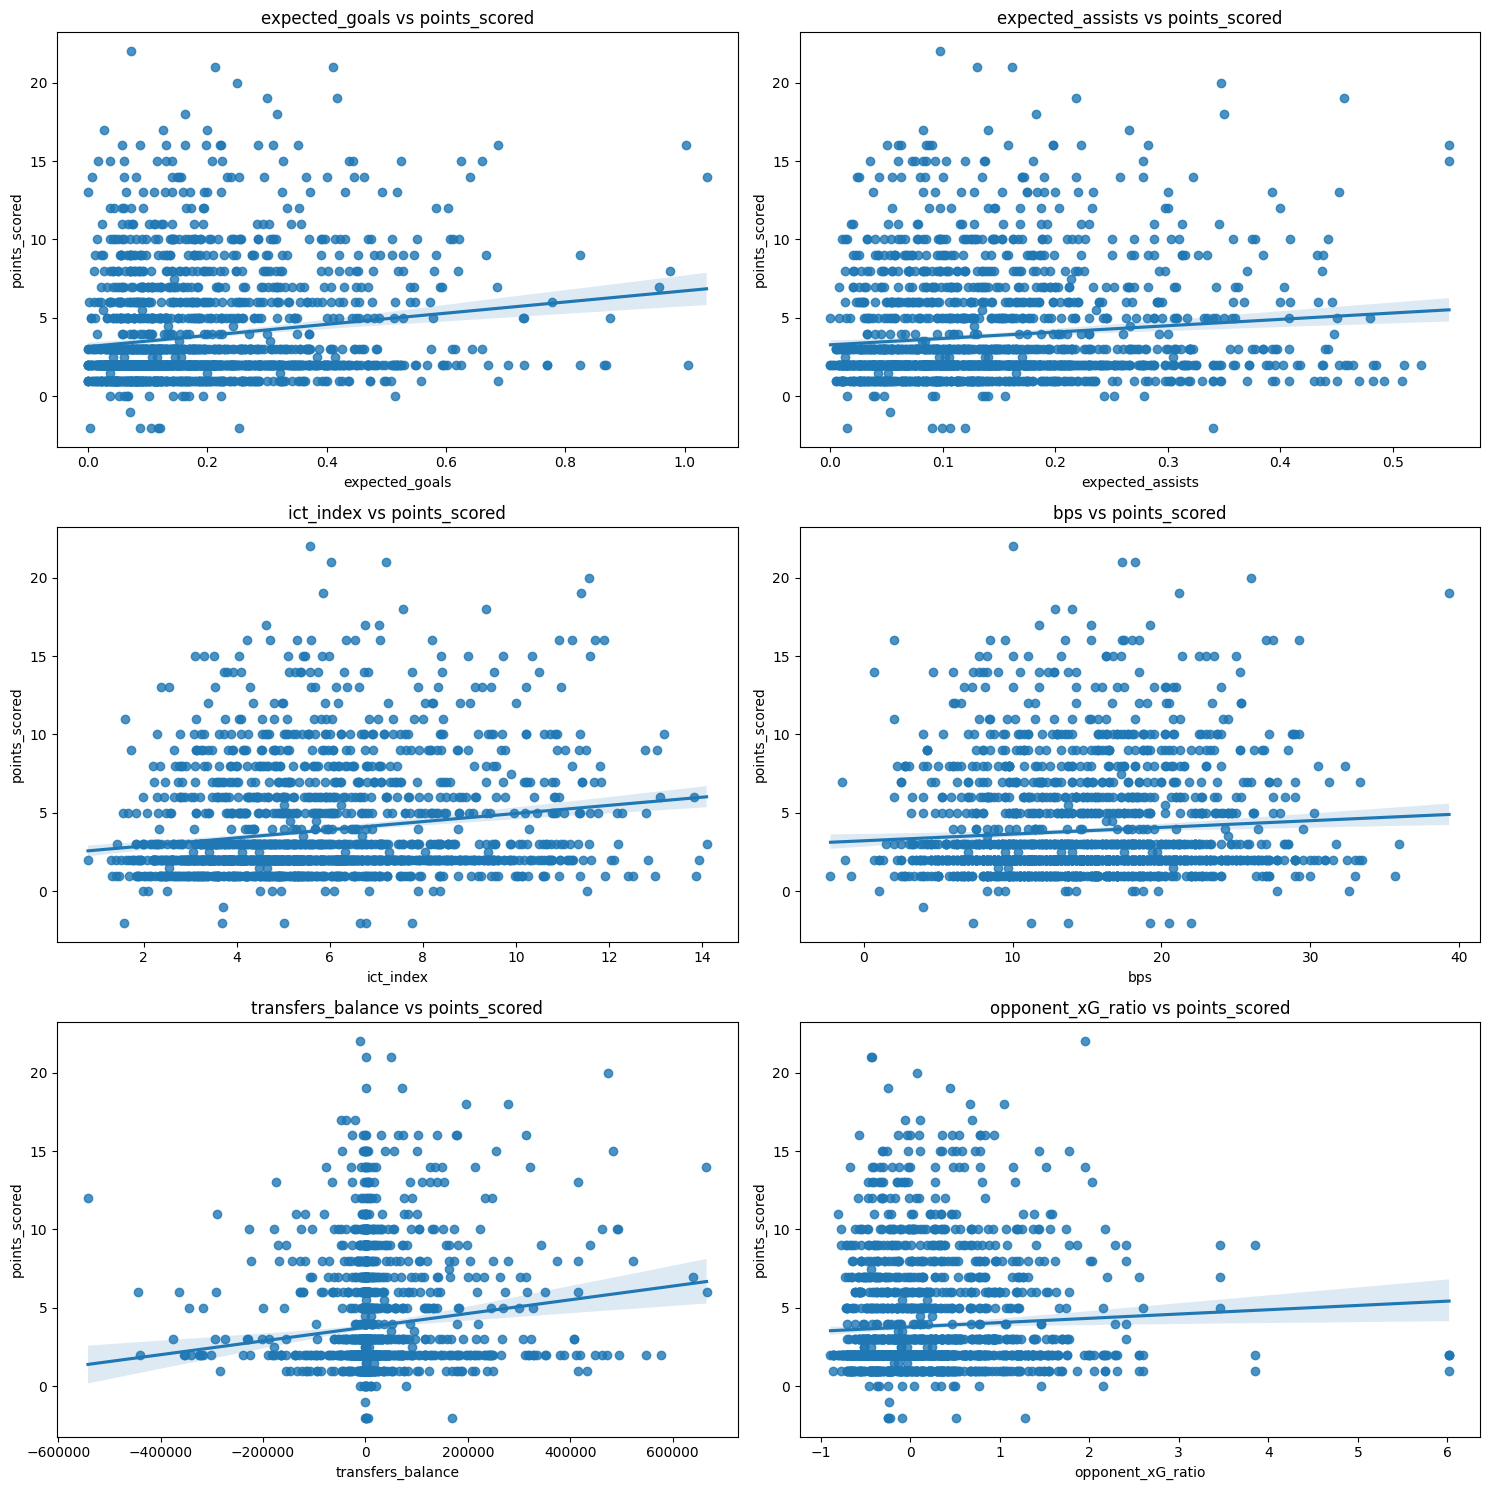

In [15]:
plot_feature_target_relationship(mid_data, 'points_scored',  features_to_plot)

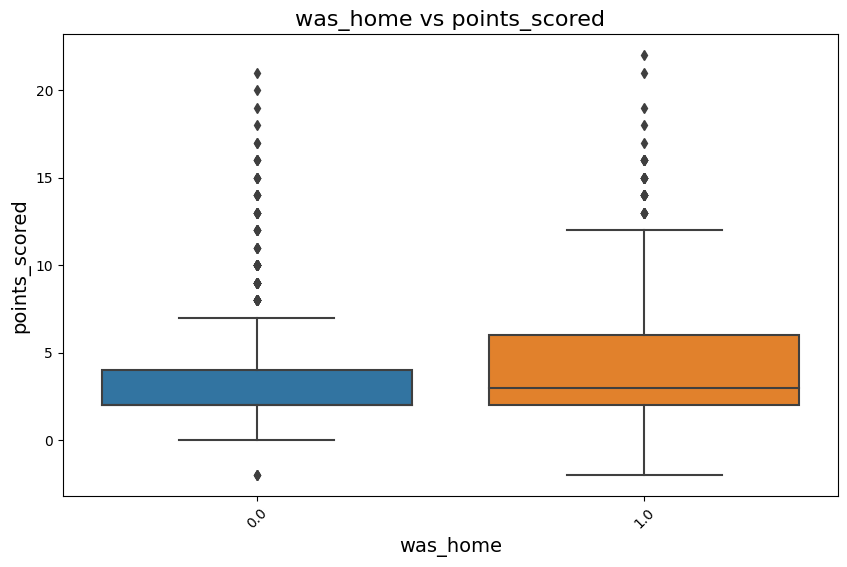

In [16]:
plot_home_vs_points(mid_data, 'was_home', 'points_scored')

# Model

In [17]:
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

class MyPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        self.scaler = None  

    def fit(self, X, y=None):
        if self.scaler is not None:
            self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        if self.scaler is not None:
            X = self.scaler.transform(X)
        return self.pca.transform(X)

    def fit_transform(self, X, y=None):
        if self.scaler is not None:
            X = self.scaler.fit_transform(X)
        return self.pca.fit_transform(X)

## Model Class

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn import metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [19]:
class ModelClass:
    def __init__(self, data, regressor):
        self.data = data
        self.pipe = None
        self.regressor = regressor

    def _initialize_pipeline(self, transformer=None, pca=None):
        steps = [('preprocessor', transformer)]
        if pca is not None:
            steps.append(('pca', pca))
        steps.append(('regressor', self.regressor))
        pipe = Pipeline(steps=steps)
        return pipe

    def cross_val_score(self, transformer, pca=None):
        X = self.data.copy()
        y = X.pop('points_scored')
        cv = KFold(n_splits=10, shuffle=True, random_state=42)
        pipe = self._initialize_pipeline(transformer, pca)
        scores = cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error')
        
        return -scores.mean()
        
    def fit_pipe(self, transformer, pca):
        self.pipe = self._initialize_pipeline(transformer, pca)
        X = self.data.copy()
        y = X.pop('points_scored')
        self.pipe.fit(X, y)

    def predictions(self, position, gw):
        self.pred_data = PredData(gw).df
        self.X_pred = position_dataset(position, self.pred_data, prediction=True)
        data = self.pipe.predict(self.X_pred)
        pred = pd.DataFrame(data, index=self.X_pred.index, columns=['xP'])#, 'Price'])
        pred = pred.join(self.X_pred.value)
        pred['Pos'] = position
        return pred.sort_values(by=['xP'], ascending=False)
    
    def future_predictions(self, position, gw, pred_range):
        predictions = []
        for i in range(pred_range):
            pred = PredData(gw, look_ahead=i).df
            X_pred = pred_position_dataset(position, pred)
            predictions.append(pd.DataFrame(self.pipe.predict(X_pred), index=X_pred.index, columns=['xP_'+str(i+1)])) 
        future_predictions = pd.merge(predictions[0], predictions[1], on='name')
        for i in range(pred_range-2):
            future_predictions= future_predictions.merge(predictions[i+2], on='name')
        future_predictions['mean_value'] = future_predictions.mean(axis=1)
        future_predictions = future_predictions.sort_values(by='mean_value', ascending=False)       
        return future_predictions

# Model Evaluation

In [20]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [21]:
pcas = [None, MyPCA(10), MyPCA(16), MyPCA(22)] 
transformers = [StandardScaler(), PowerTransformer(), None]

## Defenders

### Linear Regression 

In [22]:
linear_model = ModelClass(def_data, LinearRegression())
for pca in pcas:
    for transformer in transformers:
        score = linear_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.4798
transformer: PowerTransformer(), pca: None got score: 2.5276
transformer: None, pca: None got score: 2.4798
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.5356
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.5114
transformer: None, pca: MyPCA(n_components=10) got score: 2.5367
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.5049
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.5203
transformer: None, pca: MyPCA(n_components=16) got score: 2.4909
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.4887
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.5260
transformer: None, pca: MyPCA(n_components=22) got score: 2.4894


In [23]:
best_linear_model = ModelClass(def_data, LinearRegression())
best_linear_model.fit_pipe(None, None)
def_linear_predictions = pd.DataFrame(best_linear_model.predictions('DEF', 25))

### Lasso Regression

In [24]:
lasso_model = ModelClass(def_data, Lasso())
for pca in pcas:
    for transformer in transformers:
        score = lasso_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.6363
transformer: PowerTransformer(), pca: None got score: 2.6363
transformer: None, pca: None got score: 2.5503
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.6359
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.6335
transformer: None, pca: MyPCA(n_components=10) got score: 2.5567
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.6359
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.6335
transformer: None, pca: MyPCA(n_components=16) got score: 2.5567
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.6359
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.6335
transformer: None, pca: MyPCA(n_components=22) got score: 2.5567


In [25]:
best_lasso_model = ModelClass(def_data, Lasso())
best_lasso_model.fit_pipe(None, None)
def_lasso_predictions = pd.DataFrame(best_lasso_model.predictions('DEF', 25))

### Ridge Regression

In [26]:
ridge_model = ModelClass(def_data, Ridge())
for pca in pcas:
    for transformer in transformers:
        score = ridge_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.4830
transformer: PowerTransformer(), pca: None got score: 2.5270
transformer: None, pca: None got score: 2.4855
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.5357
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.5114
transformer: None, pca: MyPCA(n_components=10) got score: 2.5367
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.5050
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.5202
transformer: None, pca: MyPCA(n_components=16) got score: 2.4910
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.4887
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.5259
transformer: None, pca: MyPCA(n_components=22) got score: 2.4866


In [27]:
best_ridge_model = ModelClass(def_data, Ridge())
best_ridge_model.fit_pipe(StandardScaler(), None)
def_ridge_predictions = pd.DataFrame(best_ridge_model.predictions('DEF', 25))

## Midfielders

### Linear Model

In [28]:
linear_model = ModelClass(mid_data, LinearRegression())
for pca in pcas:
    for transformer in transformers:
        score = linear_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.4199
transformer: PowerTransformer(), pca: None got score: 2.4126
transformer: None, pca: None got score: 2.4199
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.4278
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.4193
transformer: None, pca: MyPCA(n_components=10) got score: 2.4715
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.4276
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.4215
transformer: None, pca: MyPCA(n_components=16) got score: 2.4272
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.4235
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.4224
transformer: None, pca: MyPCA(n_components=22) got score: 2.4231


In [29]:
best_linear_model = ModelClass(mid_data, LinearRegression())
best_linear_model.fit_pipe(None, None)
mid_linear_predictions = pd.DataFrame(best_linear_model.predictions('MID', 25))

### Lasso Model

In [30]:
lasso_model = ModelClass(mid_data, Lasso())
for pca in pcas:
    for transformer in transformers:
        score = lasso_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.6136
transformer: PowerTransformer(), pca: None got score: 2.6136
transformer: None, pca: None got score: 2.4788
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.5631
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.5633
transformer: None, pca: MyPCA(n_components=10) got score: 2.4802
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.5631
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.5633
transformer: None, pca: MyPCA(n_components=16) got score: 2.4802
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.5631
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.5633
transformer: None, pca: MyPCA(n_components=22) got score: 2.4802


In [31]:
best_lasso_model = ModelClass(mid_data, Lasso())
best_lasso_model.fit_pipe(None, None)
mid_lasso_predictions = pd.DataFrame(best_lasso_model.predictions('MID', 25))

### Ridge Model

In [32]:
ridge_model = ModelClass(mid_data, Ridge())
for pca in pcas:
    for transformer in transformers:
        score = ridge_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.4195
transformer: PowerTransformer(), pca: None got score: 2.4124
transformer: None, pca: None got score: 2.4203
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.4279
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.4193
transformer: None, pca: MyPCA(n_components=10) got score: 2.4715
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.4276
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.4215
transformer: None, pca: MyPCA(n_components=16) got score: 2.4272
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.4234
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.4224
transformer: None, pca: MyPCA(n_components=22) got score: 2.4229


In [33]:
best_ridge_model = ModelClass(mid_data, Ridge())
best_ridge_model.fit_pipe(None, None)
mid_ridge_predictions = pd.DataFrame(best_ridge_model.predictions('MID', 25))

## Forwards

### Linear Model

In [34]:
linear_model = ModelClass(mid_data, LinearRegression())
for pca in pcas:
    for transformer in transformers:
        score = linear_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.4199
transformer: PowerTransformer(), pca: None got score: 2.4126
transformer: None, pca: None got score: 2.4199
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.4278
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.4193
transformer: None, pca: MyPCA(n_components=10) got score: 2.4715
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.4276
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.4215
transformer: None, pca: MyPCA(n_components=16) got score: 2.4272
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.4235
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.4224
transformer: None, pca: MyPCA(n_components=22) got score: 2.4231


In [35]:
best_linear_model = ModelClass(mid_data, LinearRegression())
best_linear_model.fit_pipe(None, None)
fwd_linear_predictions = pd.DataFrame(best_linear_model.predictions('FWD', 25))

### Lasso Model

In [36]:
lasso_model = ModelClass(mid_data, Lasso())
for pca in pcas:
    for transformer in transformers:
        score = lasso_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.6136
transformer: PowerTransformer(), pca: None got score: 2.6136
transformer: None, pca: None got score: 2.4788
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.5631
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.5633
transformer: None, pca: MyPCA(n_components=10) got score: 2.4802
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.5631
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.5633
transformer: None, pca: MyPCA(n_components=16) got score: 2.4802
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.5631
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.5633
transformer: None, pca: MyPCA(n_components=22) got score: 2.4802


In [37]:
best_lasso_model = ModelClass(mid_data, Lasso())
best_lasso_model.fit_pipe(None, None)
fwd_lasso_predictions = pd.DataFrame(best_lasso_model.predictions('FWD', 25))

### Ridge Model

In [38]:
ridge_model = ModelClass(mid_data, Ridge())
for pca in pcas:
    for transformer in transformers:
        score = ridge_model.cross_val_score(transformer, pca)
        print(f'transformer: {transformer}, pca: {pca} got score: {score:.4f}')

transformer: StandardScaler(), pca: None got score: 2.4195
transformer: PowerTransformer(), pca: None got score: 2.4124
transformer: None, pca: None got score: 2.4203
transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.4279
transformer: PowerTransformer(), pca: MyPCA(n_components=10) got score: 2.4193
transformer: None, pca: MyPCA(n_components=10) got score: 2.4715
transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.4276
transformer: PowerTransformer(), pca: MyPCA(n_components=16) got score: 2.4215
transformer: None, pca: MyPCA(n_components=16) got score: 2.4272
transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.4234
transformer: PowerTransformer(), pca: MyPCA(n_components=22) got score: 2.4224
transformer: None, pca: MyPCA(n_components=22) got score: 2.4229


In [39]:
best_ridge_model = ModelClass(mid_data, Ridge())
best_ridge_model.fit_pipe(None, None)
fwd_ridge_predictions = pd.DataFrame(best_ridge_model.predictions('FWD', 25))

## Goalkeepers

In [40]:
ridge_model = ModelClass(gk_data, Ridge())
score = ridge_model.cross_val_score(StandardScaler(), None)
print(f'transformer: {transformer} got score: {score:.4f}')

transformer: None got score: 2.2122


In [41]:
best_ridge_model = ModelClass(gk_data, Ridge())
best_ridge_model.fit_pipe(StandardScaler(), None)
gk_ridge_predictions = pd.DataFrame(best_ridge_model.predictions('GK', 25))

In [42]:
gk_ridge_predictions

,xP,value,Pos
name,,,
Mark Flekken,6.241906,45.0,GK
Jordan Pickford,4.150112,45.0,GK
Matz Sels,3.886306,45.0,GK
Ederson Santana de Moraes,3.878136,55.0,GK
Guglielmo Vicario,3.720369,53.0,GK
David Raya Martin,3.643445,49.0,GK
Martin Dubravka,3.575242,42.0,GK
Emiliano Martínez Romero,3.536216,52.0,GK
Alisson Ramses Becker,3.504372,57.0,GK


In [43]:
best_ridge_model.X_pred.loc['Mark Flekken']

xP                        2.450000
assists                   0.250000
bonus                     0.750000
bps                      25.000000
clean_sheets              0.250000
creativity                2.500000
expected_assists          0.002500
goals_conceded            2.000000
goals_scored              0.000000
ict_index                 3.925000
influence                36.850000
minutes                  90.000000
red_cards                 0.000000
selected             256236.750000
threat                    0.000000
total_points              4.750000
transfers_balance     -6759.750000
transfers_in          11216.750000
transfers_out         17976.500000
value                    45.000000
yellow_cards              0.250000
was_home                  1.000000
opponent_defence          1.684286
opponent_attack           1.955000
team_defence              1.807500
opponent_xG_ratio        -0.138473
Name: Mark Flekken, dtype: float64

In [44]:
player_predictions = pd.concat([gk_ridge_predictions, def_ridge_predictions, mid_ridge_predictions, fwd_ridge_predictions])

In [45]:
player_predictions = player_predictions.reset_index()

In [46]:
from pulp import LpProblem, LpVariable, lpSum, LpMaximize

data = player_predictions

model = LpProblem(name="FPL_Team_Selection", sense=LpMaximize)

selected = {i: LpVariable(cat="Binary", name=f"player_{i}") for i in range(len(data))}

model += lpSum(data.loc[i, 'xP'] * selected[i] for i in range(len(data)))

model += lpSum(data.loc[i, 'value'] * selected[i] for i in range(len(data))) <= 10000
model += lpSum(selected[i] for i in range(len(data))) == 11
model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'GK') == 1  # One goalkeeper
model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'DEF') >= 3  # At least 3 defenders
model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'MID') >= 3  # At least 3 midfielders
model += lpSum(selected[i] for i in range(len(data)) if data.loc[i, 'Pos'] == 'FWD') >= 1  # At least 1 forward
model += lpSum(selected[i] for i in range(len(data))) == 11

model.solve()

selected_players = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

for i in range(len(data)):
    if selected[i].varValue == 1:
        selected_players[data.loc[i, 'Pos']].append((data.loc[i, 'name'], data.loc[i, 'xP']))

player_names = []
expected_points = []

# Print selected players in their positions
print("Selected Team:")
print("Goalkeeper:")
for player in selected_players['GK']:
    print(f"{player[0]} - Expected Points: {player[1]}")
print("\nDefenders:")
for player in selected_players['DEF']:
    print(f"{player[0]} - Expected Points: {player[1]}")
print("\nMidfielders:")
for player in selected_players['MID']:
    print(f"{player[0]} - Expected Points: {player[1]}")
print("\nForwards:")
for player in selected_players['FWD']:
    print(f"{player[0]} - Expected Points: {player[1]}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/7948204bc6f540aeb9f3fc00835745e0-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/7948204bc6f540aeb9f3fc00835745e0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 1574 RHS
At line 1582 BOUNDS
At line 1806 ENDATA
Problem MODEL has 7 rows, 223 columns and 892 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 70.1291 - 0.00 seconds
Cgl0004I processed model has 6 rows, 210 columns (210 integer (206 of which binary)) and 630 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -70.1291
Cbc0038I Cleaned solution of -70.1291
Cbc0038I Before mini branch and bound, 210 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not